In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import xarray as xr

from beamforming import (
    Beamformer,
    CorrBeamformer,
    SlidingBeamformer,
    polar_grid,
)

## Data generation

In [16]:
# Parameters
nch = 100  # number of receivers
fs = 100.0  # sampling rate
nt = 512  # number of samples

t = np.arange(nt) / fs

# Generate receiver locations
L = 2000  # length of the cable
d = L / nch
s = d / 2 + d * np.arange(nch)

a = L / 3
h = a * np.sqrt(3) / 2
sp = a * np.arange(4)
xp = [-a / 2, a / 2, 0, -a / 2]
yp = [-h / 3, -h / 3, 2 * h / 3, -h / 3]
x = np.interp(s, sp, xp)
y = np.interp(s, sp, yp)
coords = xr.Dataset(
    {
        "x": ("station", x),
        "y": ("station", y),
    }
)

source_azimuth = np.deg2rad(270)
source_t0 = -3.0
source_distance = 10000
source_speed = 2000
xs = source_distance * np.sin(source_azimuth)
ys = source_distance * np.cos(source_azimuth)


# Generate random data
np.random.seed(42)
data = np.random.randn(nch, nt)
toa = np.zeros(nch)
for idx in range(nch):
    toa[idx] = source_t0 + np.hypot(x[idx] - xs, y[idx] - ys) / source_speed
    data[idx] += 2.0 * scipy.signal.gausspulse(
        t - toa[idx], fc=5.0, bw=1.0 / 5
    )
da = xr.DataArray(data, {"time": t}, dims=("station", "time"))


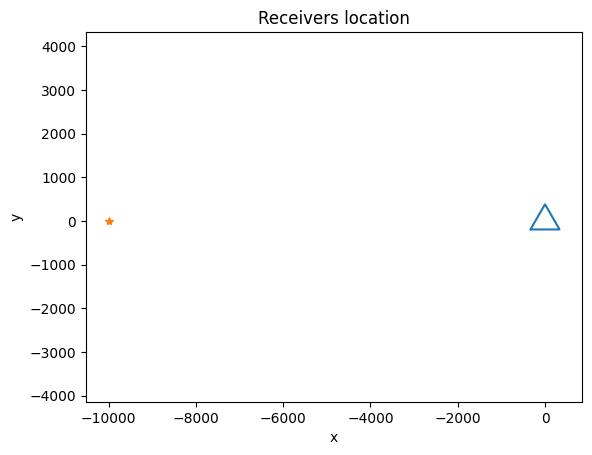

In [17]:
plt.plot(x, y)
plt.plot(xs, ys, "*")
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Receivers location");

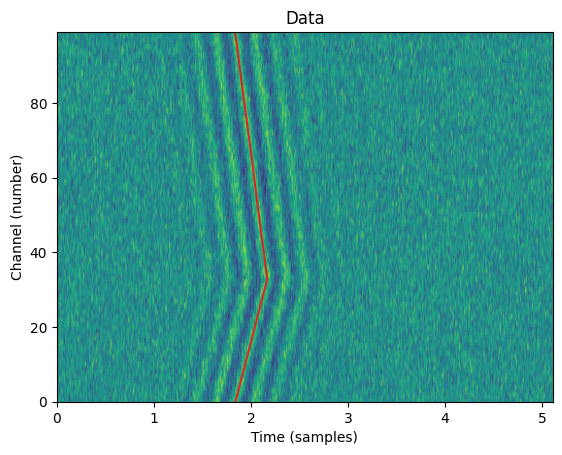

In [18]:
plt.pcolormesh(t, np.arange(nch), data, shading="gouraud")
plt.plot(toa, np.arange(nch), "C3")
plt.xlabel("Time (samples)")
plt.ylabel("Channel (number)")
plt.title("Data");

##  Beamform

In [19]:
theta = np.linspace(0, 2*np.pi, 91)
speed = np.linspace(1e-15, 5_000, 31)
grid = polar_grid(theta, speed)
beamformer = Beamformer(
    coords=coords,
    grid=grid,
    sampling_rate=fs,
    frequency_band=(5.0, 15.0),
    adaptative=True,
    n_tapers=3,
    n_sources=1,
)

In [20]:
P = beamformer.beamform(da)
P = xr.DataArray(P, {"azimuth": theta, "speed": speed})

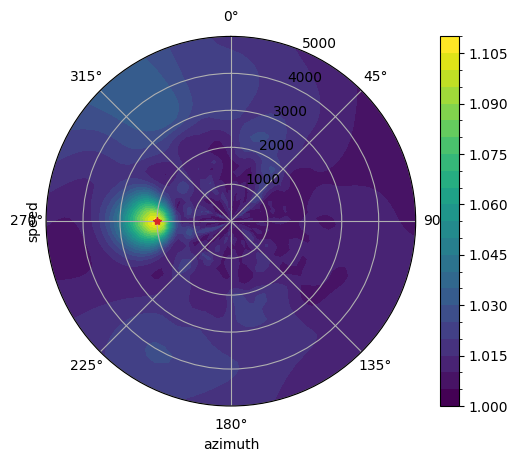

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
P.plot.contourf(ax=ax, x="azimuth", y="speed", cmap="viridis", levels=25)
ax.plot(source_azimuth, source_speed, "C3*")
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

## Sliding Beamform

In [22]:
theta = np.linspace(0, 2*np.pi, 91)
speed = np.linspace(1e-15, 5_000, 31)
grid = polar_grid(theta, speed)
beamformer = SlidingBeamformer(
    coords=coords,
    grid=grid,
    frequency_band=(5.0, 15.0),
    nperseg=32,
)

In [23]:
P = beamformer.beamform(da)

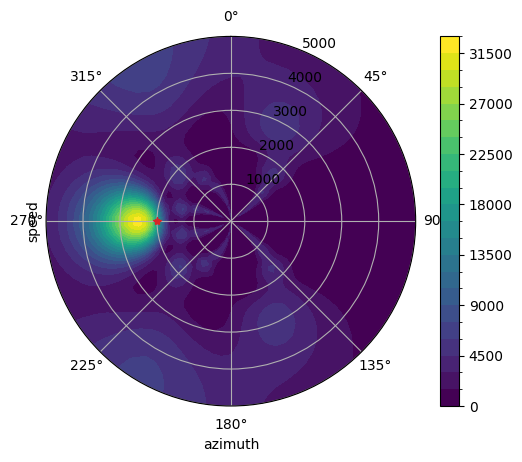

In [24]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
P.sum("time").plot.contourf(ax=ax, x="azimuth", y="speed", cmap="viridis", levels=25)
ax.plot(source_azimuth, source_speed, "C3*")
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

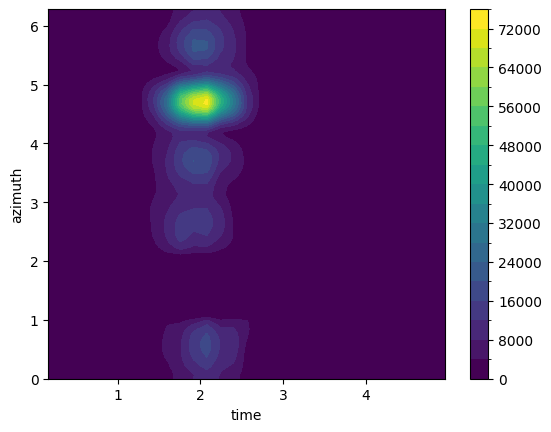

In [25]:
P.sum("speed").plot.contourf(levels=25)

## Correlation Beamformer

In [26]:
theta = np.linspace(0, 2*np.pi, 91)
speed = np.linspace(1e-15, 5_000, 31)
grid = polar_grid(theta, speed)
beamformer = CorrBeamformer(
    coords=coords,
    grid=grid,
    frequency_band=(5.0, 15.0),
    nperseg=32,
    mode="capon"
)

In [27]:
P = beamformer.beamform(da)

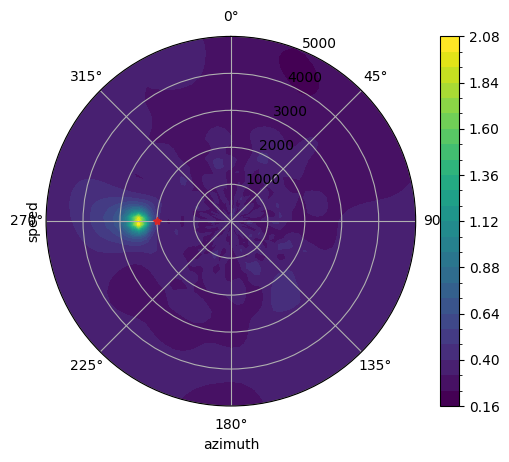

In [28]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
P.plot.contourf(ax=ax, x="azimuth", y="speed", cmap="viridis", levels=25, center=False)
ax.plot(source_azimuth, source_speed, "C3*")
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)